#Trabajo practico 1: Reserva de Hotel

**Trabajo Práctico 1 : Reservas de Hotel**

# Grupo 33
#Integrantes:
1.   Mendoza Hernandez, Sabrina Scarlet (108524)
2.   Valeriani, Matias Gabriel (108570)
3.   Jang, Lucas (109151)


#Importar librerias


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pydotplus
import warnings
import sklearn as sk
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report , f1_score
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import make_scorer

from six import StringIO
from IPython.display import Image  

from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score

#Para guardar y exportar el modelo
from joblib import dump, load
from urllib.request import urlretrieve

# Preparacion de los datasets

##Edicion del dataframe train

In [2]:
reservas = pd.read_csv("https://drive.google.com/uc?export=download&id=1NHKHnU-6LUp8ADBPsy5haPgwKOX0-LIo")
hotels = reservas.copy()
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60683 entries, 0 to 60682
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           60683 non-null  object 
 1   lead_time                       60683 non-null  int64  
 2   arrival_date_year               60683 non-null  int64  
 3   arrival_date_week_number        60683 non-null  int64  
 4   adults                          60683 non-null  int64  
 5   children                        60683 non-null  int64  
 6   country                         60683 non-null  object 
 7   market_segment                  60683 non-null  object 
 8   distribution_channel            60683 non-null  object 
 9   is_repeated_guest               60683 non-null  int64  
 10  previous_cancellations          60683 non-null  int64  
 11  previous_bookings_not_canceled  60683 non-null  int64  
 12  reserved_room_type              

* Creamos una funcion que agrupa los valores mas importantes de la variable *country*, ya que hay muchos paises con muy pocas reservas y el indice del target no es muy relevante para este caso, por lo que nos quedamos solamente con los 5 paises con mas reservas solicitadas.

In [3]:
def dummie_country(country):
    new_country = country
    if country not in ['PRT', 'ESP', 'DEU', 'FRA', 'GBR']:
      new_country = 'Other country'
    return new_country

### Conversión a variables Dummies (One hot encoding)

* Convertiremos las variables cualitativas a variables dummies. Estas nos permitirán trabajar los valores en 0 y 1, indicando si cuenta o no con dicho valor.

In [4]:
hotels['country'] = hotels['country'].apply(dummie_country)

#momentaneamente no utilizamos assigned y reserved room porque hay valores en el test que no estan en train
hotels.drop(['assigned_room_type', 'reserved_room_type'], axis='columns', inplace=True)

#Eliminamos las filas con valores "Undefined" ya que estos no se encuentran en el test
hotels = hotels[(hotels['distribution_channel'] != 'Undefined') & (hotels['market_segment'] != 'Undefined')]

In [5]:
hotels['agent'] = hotels['agent'].replace('No agent', 0)
hotels["agent"] = hotels["agent"].astype(float)

<ipython-input-5-0c6c7ff13b0c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotels['agent'] = hotels['agent'].replace('No agent', 0)
<ipython-input-5-0c6c7ff13b0c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotels["agent"] = hotels["agent"].astype(float)


In [6]:
hotels_train = hotels.copy()
hotels_train.drop('id', axis='columns', inplace=True)

target = 'is_canceled'
features = hotels_train.columns.tolist()
features.remove(target)

* Aplicamos One hot encoding a todas las variables de clase objeto, para convertir a variables dummies

In [7]:
hotels_train = pd.get_dummies(hotels_train, columns=hotels[features].select_dtypes('object').columns.tolist())

* Dividimos las variables por un lado, y el target *is_canceled* por el otro, haciendo dataframes para cada caso

In [8]:
#Features
features_para_clasificar = hotels_train.columns.tolist()
features_para_clasificar.remove(target)
df_train_completo_x = hotels_train[features_para_clasificar]

#Target
df_train_completo_y = hotels_train[target].copy()

##Edicion del dataframe test

* Una vez abierto el dataframe de test, haremos los mismos cambios realizados en el train, de modo que ambos tengan la misma cantidad de columnas.

In [9]:
reservas_test = pd.read_csv("https://drive.google.com/uc?export=download&id=1-5FFQZp2NmEqpBDGCD17e0QM0_AF7Ht2")
hotels_test = reservas_test.copy()

In [10]:
hotels_test.drop(['arrival_date_month','arrival_date_day_of_month', 'reservation_status_date','meal','babies', "company"], axis=1, inplace = True)

hotels_test['total_nights'] = hotels_test['stays_in_week_nights'] + hotels_test['stays_in_weekend_nights']
hotels_test.drop(['stays_in_week_nights', 'stays_in_weekend_nights'], axis=1, inplace = True)

hotels_test['country'] = hotels_test['country'].apply(dummie_country)
hotels_test.drop(['assigned_room_type', 'reserved_room_type'], axis='columns', inplace=True)

hotels_test['children'] = hotels_test['children'].fillna(0)
hotels_test['children']= hotels_test['children'].astype(int)

hotels_test['agent'] = hotels_test['agent'].fillna(0)
hotels_test["agent"] = hotels_test["agent"].astype(float)

* Eliminamos la variable *id* y posteriormente aplicamos one hot encoding tal como lo habiamos hecho en el train.

In [11]:
hotels_test_ = hotels_test.copy()

hotels_test_.drop('id', axis='columns', inplace=True)

features = hotels_test_.columns.tolist()

hotels_test_ = pd.get_dummies(hotels_test_, columns=hotels_test_[features].select_dtypes('object').columns.tolist())

# Arbol de decision

## Entrenamiento y predicción

Vamos a crear un conjunto de entrenamiento con el 70% de los datos y otro conjunto de test con el 30%.
En este apartado realizamos las combinaciones aleatorias de unos parametros para poder obtener un arbol. Posteriormente mostraremos el arbol de decision con su respetiva matriz de confusión, obtenidos en este proceso de aleatoriedad. Posteirormente haremos el mismo procedimiento con un analisis mas en profundidad del mejor modelo obtenido. 

* Veamos el balanceo del target *is_canceled*, el cual cuenta con un porcentaje muy similar de datos.

In [12]:
hotels_train[target].value_counts(normalize=True)*100

1    50.557854
0    49.442146
Name: is_canceled, dtype: float64

In [13]:
x_train, x_test, y_train, y_test = train_test_split(df_train_completo_x, 
                                                    df_train_completo_y, 
                                                    test_size=0.3,    #30% al conjunto de test
                                                    random_state=13,  #para poder reproducir el experimento
                                                    stratify=hotels[target].values) #estratificado para mantener proporcion

#Verifico Cantidad de Datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

#Verifico como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 42475
# Datos Prueba: 18204
% Positivos Entrenamiento: 50.557
% Positivos Prueba: 50.560


* Realizamos una optimizacion de parametro del arbol por medio de cross validation con una cantidad de folds de 5

In [14]:
warnings.filterwarnings('always')

#Cantidad de combinaciones que quiero porbar
n=10 

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               #'min_samples_leaf':list(range(1,10)),
               #'min_samples_split': list(range(2,20)),
               'ccp_alpha':np.linspace(0.0001,0.0005,n), 
               'max_depth':list(range(15, 24))}
                
#Cantidad de splits para el Cross Validation
folds=8
#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n)

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train,y_train);

In [15]:
#Mejores hiperparametros del arbol
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

{'max_depth': 16, 'criterion': 'gini', 'ccp_alpha': 0.0001}
0.8528424996277789


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
#Creo el árbol con los mejores hiperparámetros
base_tree = DecisionTreeClassifier().set_params(**randomcv.best_params_)

#Entreno el arbol en todo el set
base_tree.fit(x_train,y_train)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


DecisionTreeClassifier(ccp_alpha=0.0001, max_depth=16)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


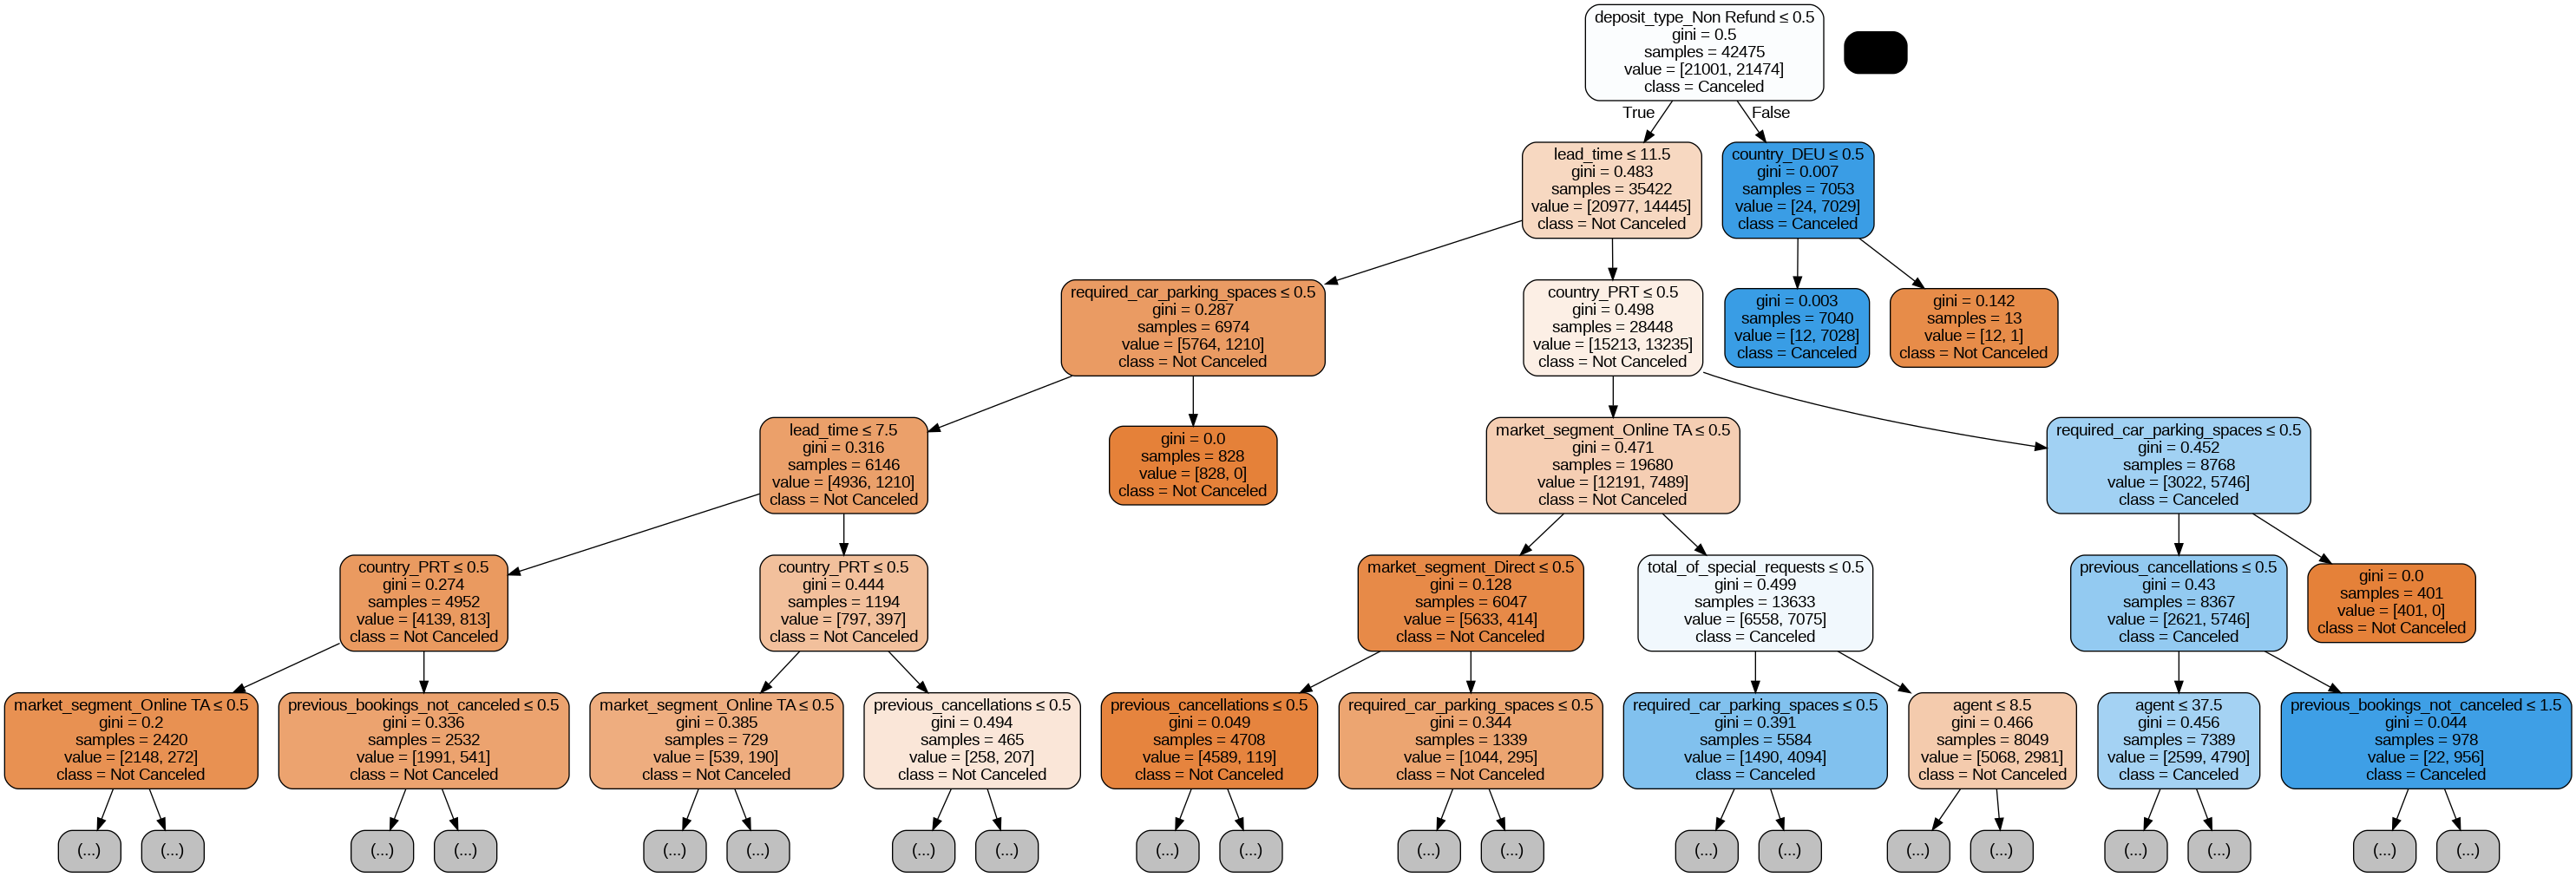

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [17]:
dot_data = StringIO()
export_graphviz(base_tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=list(df_train_completo_x),
                class_names=['Not Canceled','Canceled'],
                max_depth=5)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


              precision    recall  f1-score   support

           0       0.86      0.84      0.85      9000
           1       0.85      0.87      0.86      9204

    accuracy                           0.85     18204
   macro avg       0.85      0.85      0.85     18204
weighted avg       0.85      0.85      0.85     18204

F1-Score: 0.8578930446897439


Text(50.722222222222214, 0.5, 'True')

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen imp

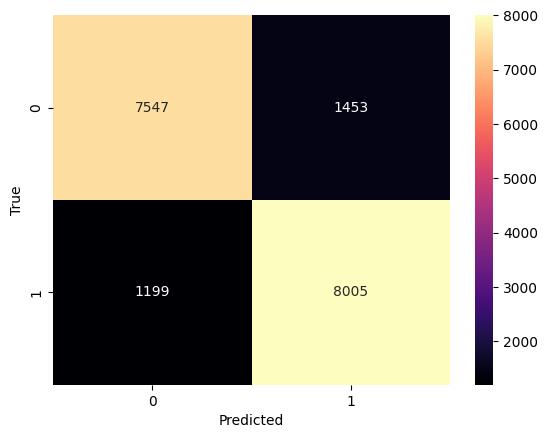

In [18]:
#Hago predicción sobre el set de evaluacion
y_pred= base_tree.predict(x_test)

#Arbol Reporte y Matriz de Confusion
print(classification_report(y_test,y_pred))
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary'))) #binary considera la clase positiva por defecto 1

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='magma',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

## Guardamos el modelo

Ahora guardamos el mejor modelo en base a nuestra conveniencia, por tal motivo esta comentado el apartado en que se guarda el mismo. Luego de varios intentos de modelos, conseguimos el mejor arbol que será evaluado posteriormente.

In [19]:
#dump(base_tree, 'max-depth-19_criterion-gini_ccp-alpha-0-0001_f1-0-85897.joblib')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Mejor arbol de decision

* Graficamos el arbol de decision con mejor performance. Por cuestiones de simplicidad, mostramos una porcion del arbol, ya que la profundidad del mismo es extensa y compleja de leer a simple vista. Para el siguiente arbol de decision decidimos utilizar 8 folds, ya que consideramos que al haber 60683 filas en el dataframe de train, obtuvimos que la mas optima divisir al utilizar cross validation es hacerla en splits de 7500 (aprox) filas por fold.

In [20]:
url = 'https://github.com/SabriMendoza/7506R-1C2023-GRUPO33/raw/main/max-depth-19_criterion-gini_ccp-alpha-0-0001_f1-0-85897.joblib'

urlretrieve(url, 'max-depth-19_criterion-gini_ccp-alpha-0-0001_f1-0-85897.joblib')

model = load('max-depth-19_criterion-gini_ccp-alpha-0-0001_f1-0-85897.joblib')

model_params = model.get_params()
print(f"criterion: {model_params['criterion']}")
print(f"max_depth: {model_params['max_depth']}")
print(f"ccp_alpha: {model_params['ccp_alpha']}")
print("f1 score: 0.85897")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


criterion: gini
max_depth: 19
ccp_alpha: 0.0001
f1 score: 0.85897


* Mostramos los 20 features mas utilizados por el mejor modelo

In [21]:
feat_imps = model.feature_importances_
features = model.feature_names_in_
importancias_y_atributos = zip(feat_imps,features)

for i, imp_y_at in enumerate(sorted(importancias_y_atributos, reverse=True)):
  feat_imp, feat = imp_y_at[0], imp_y_at[1]
  if 20 and i == 20:
    break
  if feat_imp > 0:
    print(f"{i+1}. {feat}: {feat_imp}")

1. deposit_type_Non Refund: 0.30510238200682965
2. market_segment_Online TA: 0.13166781580809558
3. lead_time: 0.10183112160686554
4. agent: 0.08458513413635169
5. total_of_special_requests: 0.0803624274692788
6. country_PRT: 0.07187828308189706
7. required_car_parking_spaces: 0.05453175866501479
8. arrival_date_year: 0.03303394706169463
9. previous_cancellations: 0.02420167066585139
10. adr: 0.021380411582946016
11. customer_type_Transient: 0.020254294390958733
12. arrival_date_week_number: 0.020085216642231566
13. booking_changes: 0.013199676387950148
14. total_nights: 0.007444355358916311
15. market_segment_Direct: 0.005933490291384383
16. is_repeated_guest: 0.004399616376259622
17. previous_bookings_not_canceled: 0.004287529774416022
18. customer_type_Transient-Party: 0.00409876079828875
19. country_DEU: 0.0024155794048678547
20. days_in_waiting_list: 0.002224186535878533


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


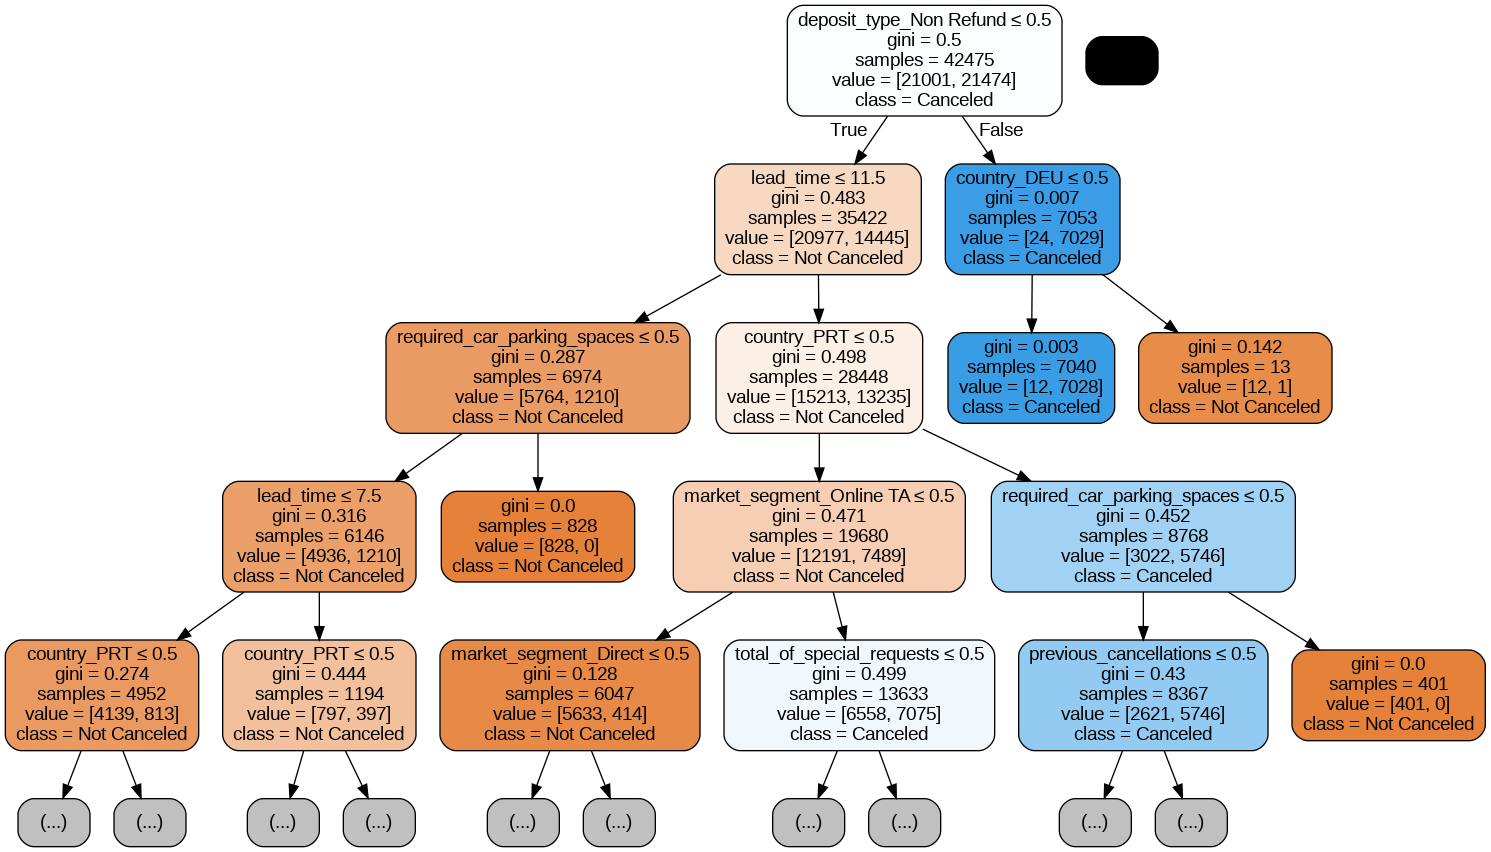

In [22]:
feature_names = df_train_completo_x.columns.to_list()

dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=feature_names,
                class_names=['Not Canceled','Canceled'],
                max_depth=4)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

En el arbol se observa que los nodos naranjas, nos indican que la reserva no sera cancelada, dando a entender que el nodo mas anaranjado es el que define que la reserva no se canceló.
Con el caso del color azul, tiene a la reserva cancelada mientra mas azul esté el nodo.

En el arbol vemos que en la raíz se encuentra el tipo de deposito non refund, y pregunta si es *Non Refund* o no. En el caso que el tipo de deposito sea *Non Refund* va a bifurcar para el lado del False, ya que al ser de ese tipo, seria el atributo 1. Si no es *Non Refund*, el atributo seria 0 en dicha variable, por lo que en el arbol bifurcaria para el lado del True.

En el caso de la raiz, vemos como la mitad de los casos se dividen. Y hace la bifurcacion, de un lado a lead time y por el otro a DEU que corresponde a la variable *country*.
De aca mismo podemos ver que obtenemos un nodo en el que ya nos determina que una reserva se canceló. 
Por ejemplo si el tipo de deposito es Non Refund, nos bifurca hacia el nodo que consulta si el pais es o no DEU. En caso que lo sea, nos dice que la reserva no se canceló. Caso contrario (que el pais no sea DEU, es decir <= 0) indica que la reserva se canceló.

Posteriormente en un nivel mas bajo se encuentra *required_car_parking_space*, *country_PRT*. 
En el caso de que requiera a partir de 1 plaza de estacionamiento, y que el tipo de deposito NO sea Non Refund, deduce que la reserva no será cancelada.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


              precision    recall  f1-score   support

           0       0.87      0.84      0.85      9000
           1       0.84      0.87      0.86      9204

    accuracy                           0.85     18204
   macro avg       0.86      0.85      0.85     18204
weighted avg       0.86      0.85      0.85     18204

F1-Score: 0.8589729902850431


Text(50.722222222222214, 0.5, 'True')

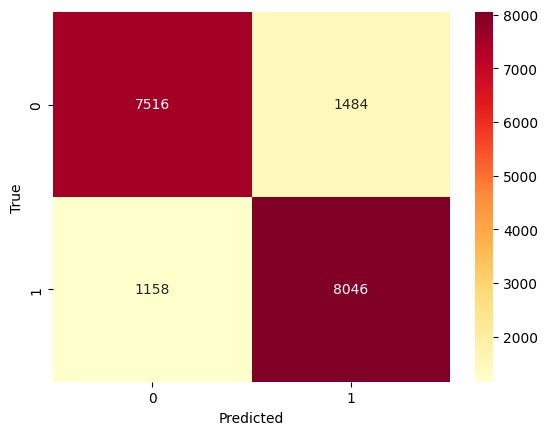

In [23]:
y_pred= model.predict(x_test)

print(classification_report(y_test,y_pred))
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary'))) #binary considera la clase positiva por defecto 1

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='YlOrRd',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Las métricas mostradas anteriormente se obtienen de la matriz de confusion. Con esta matriz se puede obtener precision, recall, f1 score y accuracy. 

La precisión (precision) mide la proporción de verdaderos positivos (TP) entre los casos positivos pronosticados (TP + FP). Mide la capacidad del modelo para predecir correctamente los casos positivos.

El recall (recall) mide la proporción de verdaderos positivos (TP) entre todos los casos positivos reales (TP + FN). Mide la capacidad del modelo para encontrar todos los casos positivos.

El F1 score (f1 score) es la media armónica entre la precisión y el recall. Resume el rendimiento del modelo en términos de clasificación.

La exactitud (accuracy) mide la proporción de casos totales que se clasifican correctamente (TP + TN) sobre el total de casos (TP + TN + FP + FN). Mide la capacidad del modelo para clasificar correctamente todos los casos, tanto positivos como negativos.

$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$

$Precision = \frac{TP}{TP + FP}$

$Recall = \frac{TP}{TP + FN}$

$F1 Score = \frac{2.Precision.Recall}{Precision + Recall}$


# Submission

In [24]:
y_pred = model.predict(hotels_test_)

df_submission = pd.DataFrame({'id': hotels_test['id'], 'is_canceled': y_pred})
df_submission.to_csv('submission1.csv',index=False) 


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
